## Examining biases in models

In [1]:
import torch
import clip
from PIL import Image

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## What is a bias in a ML model?

A bias in a ML model is a **systematic error that makes the model to predict a certain class with a higher probability than it should**. 

This can be due to several reasons, such as:
* The dataset used to train the model contains biases from the real world, such as gender disparities, racial disparities, etc.
* Typically, the training of the models exacerbates these biases, as the model learns to overrepresent the majority groups and underrepresent the minority groups.

**Biases are of critical importance, specially in ML models that have been pre-trained on vast amounts of data from the Internet, such as CLIP or GPT. These models are trained on the Internet, and the Internet is full of biases, stereotypes...**

There are several types of biases that may be present in ML models:

1. **Cultural biases**: the model may be biased towards certain cultures, for example, it may be biased towards white people, or towards people from the US. It may also have learnt about cultural stereotypes, such as job roles.

2. **Technical biases**: these are more subtle to detect. For example, the model may be biased towards certain types of images, such as images with a certain resolution, or images with a certain background. We will see an example about this later.

### 1. Cultural biases

Let's create a function that, given a text label, and several images, it computes the probability of the label for each image (that is, like semantic search). Then, we can use this function to examine biases in models.

In [3]:
def plot_probas(images_paths, text_label):
    images = [preprocess(Image.open(image_path)).unsqueeze(0).to(device) for image_path in images_paths]
    images = torch.cat(images)
    text = clip.tokenize([text_label]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(images)
        text_features = model.encode_text(text)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        probabilities = (100.0 * image_features @ text_features.T).softmax(dim=0)

    # Plot the two images side by side, printing the probability under each image
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    for i, ax in enumerate(axs):
        ax.imshow(Image.open(images_paths[i]))
        ax.axis("off")
        ax.set_title(f"Probability: {probabilities[i].item():.2f}")

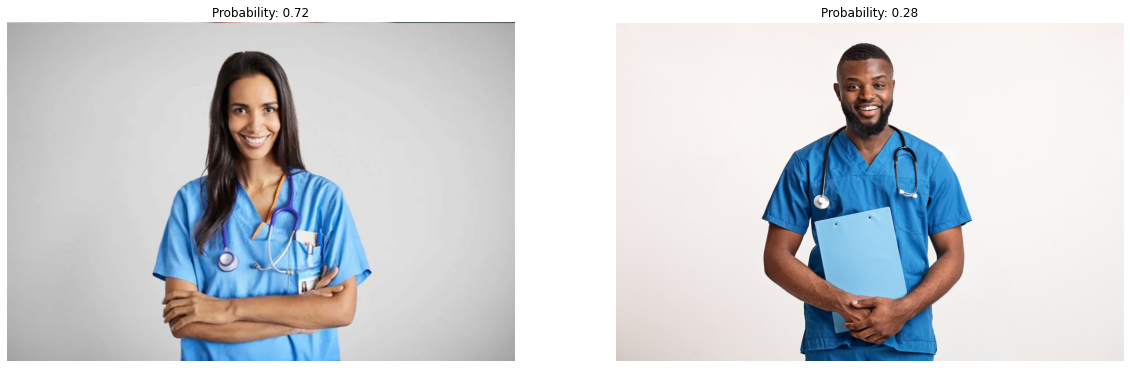

In [58]:
images_paths = ["images/nurse1.webp", "images/nurse2.jpg"]
text_label = "a photo of a nurse"

plot_probas(images_paths, text_label)


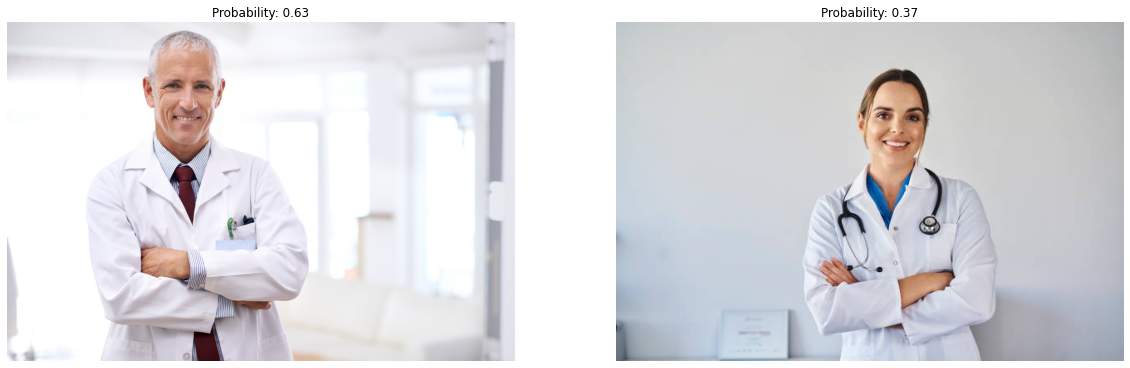

In [59]:
images_paths = ["images/doctor1.jpg", "images/doctor2.jpg"]
text_label = "a photo of a doctor"

plot_probas(images_paths, text_label)

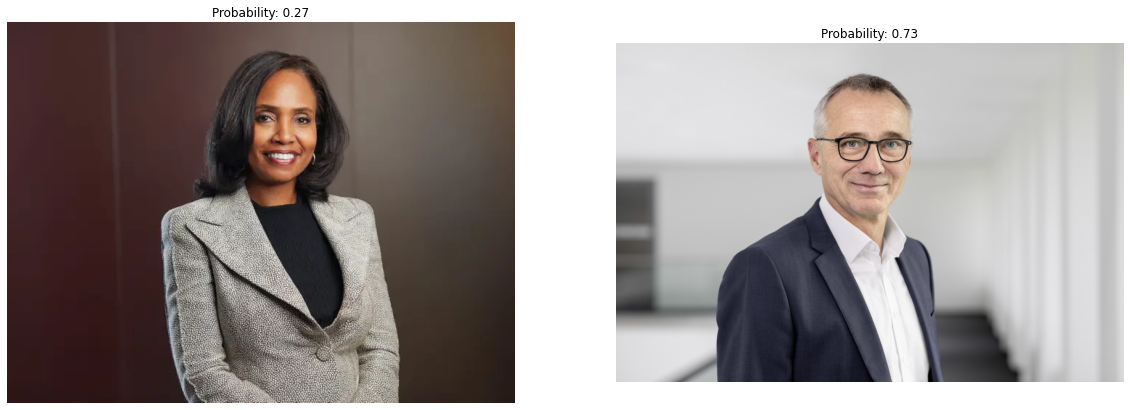

In [60]:
images_paths = ["images/ceo1.webp", "images/ceo2.jpg"]
text_label = "a photo of a CEO"

plot_probas(images_paths, text_label)

* To the left: https://www.siebertwilliams.com/suzanne-shank-bio 
* To the right: https://www.sustainable-bus.com/news/andreas-tostmann-ceo-man-truck-bus-joachim-drees-leaves/ 

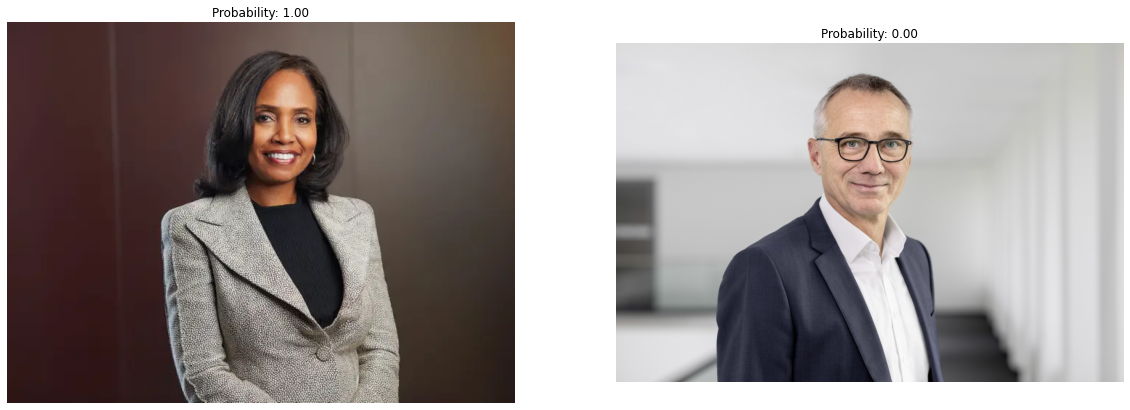

In [61]:
images_paths = ["images/ceo1.webp", "images/ceo2.jpg"]
text_label = "a photo of a woman CEO"

plot_probas(images_paths, text_label)

**Exercise** Identify other examples, not related to people, in which we can see biases present in the data.

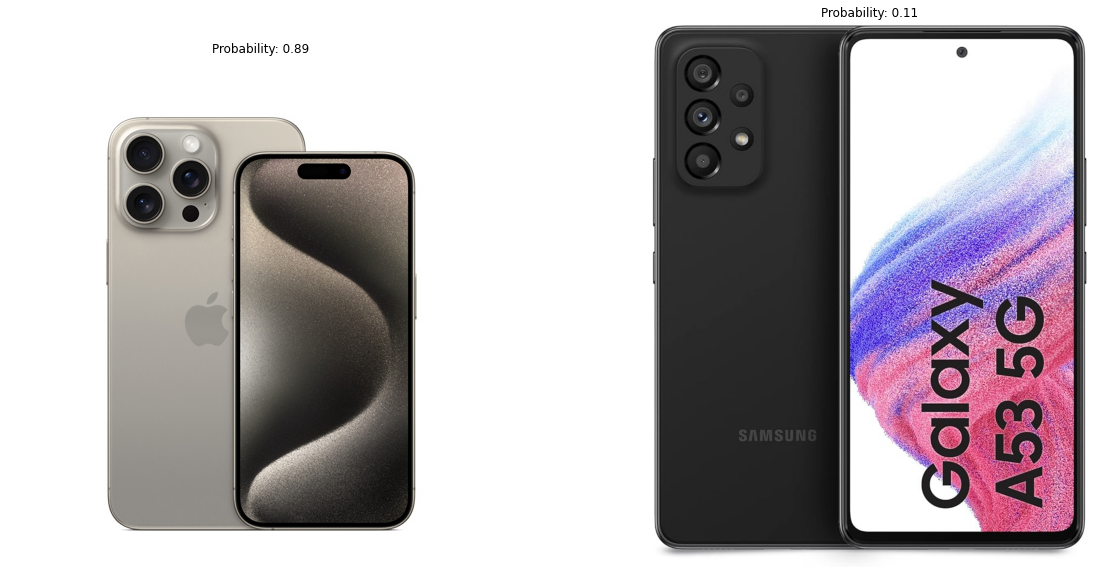

In [62]:
images_paths = ["images/phone.jpeg", "images/phone2.jpg"]
text_label = "a photo of a smartphone"

plot_probas(images_paths, text_label)




## Is there any solution to rectify this AI bias?

There are several actionable steps, including **investing in geographically and culturally diverse datasets**, **defining evaluation metrics that account for diversity**, and **documenting the demographics of data on which the AI is trained**.

### 2. Technical biases

Let's explore a technical bias present in the CLIP model.

In [8]:
def compute_probabilities_per_image(image, labels):

    image = preprocess(image).unsqueeze(0).to(device)
    text = clip.tokenize(labels).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    for i, label in enumerate(labels):
        print(f"Label: {label:<14} Probability: {probs[0, i]:.2f}")

In [5]:
labels = ["Granny Smith apple", "keyring", "iPod", "Husky dog", "bag"]

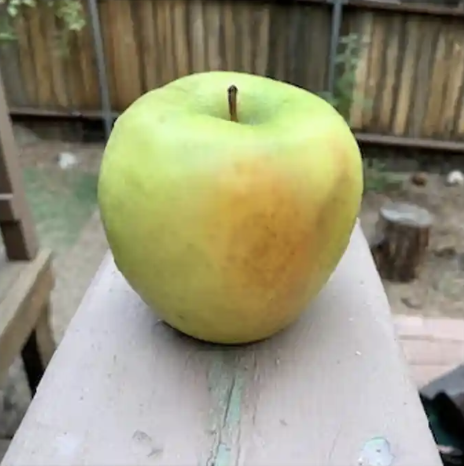

In [6]:
image = Image.open("images/c1.png")
image

In [9]:
compute_probabilities_per_image(image, labels)

Label: Granny Smith apple Probability: 1.00
Label: keyring        Probability: 0.00
Label: iPod           Probability: 0.00
Label: Husky dog      Probability: 0.00
Label: bag            Probability: 0.00


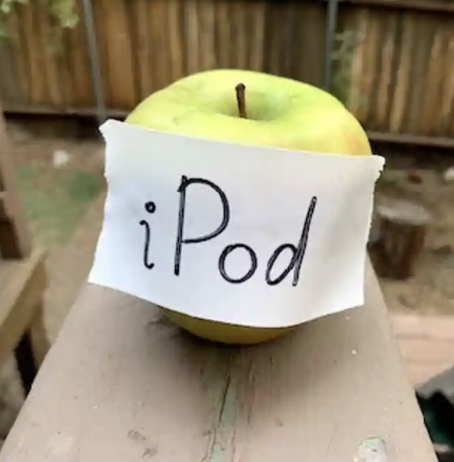

In [10]:
image = Image.open("images/c2.png")
image

In [11]:
compute_probabilities_per_image(image, labels)

Label: Granny Smith apple Probability: 0.08
Label: keyring        Probability: 0.00
Label: iPod           Probability: 0.91
Label: Husky dog      Probability: 0.00
Label: bag            Probability: 0.00


In [12]:
labels = ["Granny Smith apple", "keyring", "iPod", "Husky dog", "bag", "piggy bank", "Poodle dog"]

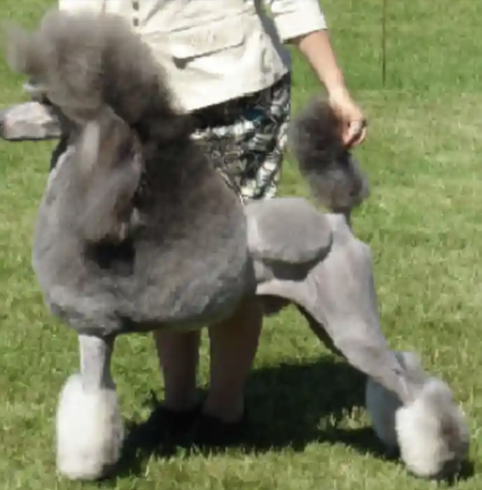

In [13]:
image = Image.open("images/c3.png")
image

In [14]:
compute_probabilities_per_image(image, labels)

Label: Granny Smith apple Probability: 0.00
Label: keyring        Probability: 0.00
Label: iPod           Probability: 0.00
Label: Husky dog      Probability: 0.01
Label: bag            Probability: 0.00
Label: piggy bank     Probability: 0.00
Label: Poodle dog     Probability: 0.99


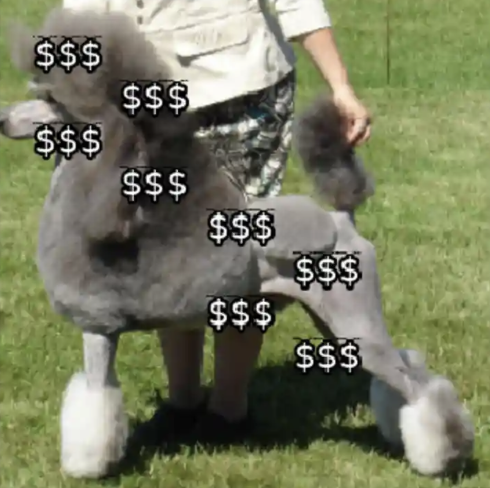

In [15]:
image = Image.open("images/c4.png")
image

In [16]:
compute_probabilities_per_image(image, labels)

Label: Granny Smith apple Probability: 0.00
Label: keyring        Probability: 0.00
Label: iPod           Probability: 0.00
Label: Husky dog      Probability: 0.00
Label: bag            Probability: 0.03
Label: piggy bank     Probability: 0.77
Label: Poodle dog     Probability: 0.19


**The previous examples show that the CLIP model is biased towards predicting the text that appears in the photo, giving it more attention than the actual content of the image.**

This is a common failure mode of these types of models that is also called **typographic attack**.

https://www.theverge.com/2021/3/8/22319173/openai-machine-vision-adversarial-typographic-attacka-clip-multimodal-neuron

## Biases in generative models

Whereas in the previous examples the bias was in the model's predictions, generative models (we will study them at the end of the course) also may have biases in the data they generate.

For example, let's study the recent `stable-cascade`, a model to generate images from a text description.

**Exercise** Go to https://huggingface.co/spaces/multimodalart/stable-cascade, which is a space to try out this model, and generate several samples using the following prompt: 

`A photo of a person`.

Can you identify biases in the generations for this prompt?